In [1]:
from typing import List, TypedDict, Tuple, Dict, Optional, Union
SensorData = TypedDict('dict', A=float, N=float, x=float, y=float)
Sensors = Dict[str, SensorData]
SenseData = List[int]
Distance = Tuple[str, float]
Distances = List[Distance]
Point = Tuple[float, float]

# 手动输入数据

In [2]:
# 根据嗅探器id填入数据，每个嗅探器的rssi值组成一个list
sense_datas = [('00f4041c',[-70,-71,-72,-71]),('00f40443',[-66,-67,-68,-68]),('00f40463',[-66,-67,-68,-69])]
# 真实结果
true_position = [2.5,8.0]

# 手动选择模式

In [3]:
# 是否在计算距离时平均（平均所有），默认平均
average_in_distance = True
# 是否在计算最终点时平均（平均所有），默认不平均
average_in_position = False
# 'LSM'-最小二乘法， 其他字符串-三角形质心法
way = 'LSM' #'CM' 

## 嗅探器参数（检查一下id）

In [4]:
def get_sensors() -> Sensors:
    '''获取id升序的嗅探器配置'''
    sensor_ids = ['00f4041c','00f40443','00f40463']
    sensors = {sensor_id: dict(
            id=sensor_id,
        ) for sensor_id in sensor_ids}
    # 填补位置信息
    positions = [[0.0, 0.0], [0.0, 10.2], [6.47, 10.2]]
    # 暂用别组的参数
    # A = 51.345
    # N = 2.001
    As = [54.44, 62.78, 51.15]
    Ns = [1.98, 0.93, 2.69]
    for sensor, position, A, N in zip(sensors.values(), positions, As, Ns):
        sensor.update(
            A=A,
            N=N,
            x=position[0],
            y=position[1],
        )
    return sensors

In [5]:
tmp_sensors = get_sensors()
tmp_sensors

{'00f4041c': {'id': '00f4041c', 'A': 54.44, 'N': 1.98, 'x': 0.0, 'y': 0.0},
 '00f40443': {'id': '00f40443', 'A': 62.78, 'N': 0.93, 'x': 0.0, 'y': 10.2},
 '00f40463': {'id': '00f40463', 'A': 51.15, 'N': 2.69, 'x': 6.47, 'y': 10.2}}

## Get Distances

In [6]:
def calculate_distance(sense_data: int, sensor: SensorData) -> float:
    return pow(10, float((abs(sense_data) - sensor['A']) / (10 * sensor['N'])))

def average_distance(distances_across_time:List[Distances]) -> List[Distances]:
    '''
    平均多个时刻的Distances为一个时刻的Distances
    '''
    # 保证多于2个时刻（后续会删除最大最小值）
    if len(distances_across_time) <= 2:
        return distances_across_time
    distance_zip = zip(*[i for i in distances_across_time])
    distance_average = []
    for distance_  in distance_zip:
        tmp = [distance[1] for distance in distance_] # List[float]
        tmp.remove(max(tmp))
        tmp.remove(min(tmp))
        tmp_average = sum(tmp) / len(tmp)
        distance_average.append ((distance_[0][0],tmp_average))
    return [distance_average]

def get_distances(sensors: Sensors,
                  sense_datas: List[Tuple[str, SenseData]],
                  average: bool = True,
                  **cal_kws) -> List[Distances]:
    
    sensors_list = [sensors[sd[0]] for sd in sense_datas]
    sense_datas_zip = zip(*[sd[1] for sd in sense_datas])
    # 计算距离
    distances_across_time = []
    for sense_data_zip in sense_datas_zip:
        # 每个时刻
        distances = []
        for sensor, sense_data in zip(sensors_list, sense_data_zip):
            # 每一个嗅探设备
            distance = calculate_distance(sense_data, sensor, **cal_kws)
            distances.append((sensor['id'], distance))
        distances_across_time.append(distances)
    if average:
        print('average distance')
        return average_distance(distances_across_time)
    return distances_across_time

In [7]:
dis = get_distances(tmp_sensors,sense_datas,average_in_distance)
dis

average distance


[[('00f4041c', 6.860624286177789),
  ('00f40443', 3.2422480387320523),
  ('00f40463', 4.056993670178649)]]

## Get Positions

### 画图部分：每计算一次位置就会画一次，多次叠加在一张图上:
平均距离之后，只计算一次位置;平均位置的话，会计算多次位置的叠加

In [8]:
def CM_plot(dis,rs,point,points,ax):
    print(point)
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    # 圆心
    for i in range(3):
        plt.plot(rs[i][0],rs[i][1],'g.')
        cir1 = Circle(xy = rs[i], radius=dis[i], alpha=0.1)
        ax.add_patch(cir1)
    # 三个圆两两的交点，并且连成三角形
    for i,p in enumerate(points):
        plt.plot(p[0],p[1],'b.')
        plt.plot([points[i][0],points[(i+1)%3][0]],[points[i][1],points[(i+1)%3][1]],label='sin')
        #ax.annotate(i,(p[0],p[1]))

    # 最终的定位点                       
    plt.plot(point[0],point[1],'r.')

    plt.axis('scaled')
    plt.axis('equal') 
    plt.title('Indoor Location')
    #plt.show()

def LSM_plot(dis,rs,point,ax):
    print(point)
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    
    # 圆心
    for i in range(3):
        plt.plot(rs[i][0],rs[i][1],'g.')
        cir1 = Circle(xy = rs[i], radius=dis[i], alpha=0.1)
        ax.add_patch(cir1)

    # 最终的定位点                       
    plt.plot(point[0],point[1],'r.')

    plt.axis('scaled')
    plt.axis('equal')   
    plt.title('Indoor Location')
    #plt.show()


In [9]:
def cal_position_CM(distances: Distances,
                       sensors: Sensors,
                   ax) -> Point:
    '''根据距离和嗅探器位置，计算某一时刻的坐标
    返回值:point是最终的定位点
    如果两个圆有交点，验证第三个圆的半径和这个交点到圆心的距离是否相等，后者允许一定误差，若相等，算出近似交点；
    如果没有近似交点，返回三个模拟交点（每个模拟交点这样计算：相切就是切点，相离按比例取圆心连线上某点，相交取两个交点的中点）的平均。
    '''
    import math
    point = [0, 0]
    points = []  # 某两个圆的交点-可用于debug
    points3 = []
    
    dis = []  # dis是测得的距离数组
    rs = []  # rs是路由器位置（二维数组）
    for distance in distances:  # 每个嗅探设备
        dis.append(distance[1])
        rs.append([sensors[distance[0]]['x'], sensors[distance[0]]['y']])
        
    assert (len(dis) == 3)
    assert (len(rs) == 3 and len(rs[0]) == 2)
    e = 0.2  # 允许的误差范围
    found = False  # 是否已经找到近似交点
    tmpx, tmpy = 0, 0
    tmpx1, tmpy1 = 0, 0
    tmpx2, tmpy2 = 0, 0
    for i in range(3):
        assert (dis[i] >= 0)
        if found:
            break
        for j in range(i + 1, 3):
            # 路由器间的距离
            p2p = math.sqrt((rs[i][0] - rs[j][0]) * (rs[i][0] - rs[j][0]) +
                            (rs[i][1] - rs[j][1]) * (rs[i][1] - rs[j][1]))
            if dis[i] + dis[j] >= p2p:  # 两圆有交点
                dr = p2p / 2 + (dis[i] * dis[i] - dis[j] * dis[j]) / (2 * p2p)
                ddr = math.sqrt(abs(dis[i] * dis[i] - dr * dr))
                # 两个交点的中点
                tmpx = rs[i][0] + (rs[j][0] - rs[i][0]) * dr / p2p
                tmpy = rs[i][1] + (rs[j][1] - rs[i][1]) * dr / p2p
                cos = -(rs[j][1] - rs[i][1]) / p2p
                sin = (rs[j][0] - rs[i][0]) / p2p
                # 两个or一个交点
                tmpx1 = tmpx + ddr * cos
                tmpx2 = tmpx - ddr * cos
                tmpy1 = tmpy + ddr * sin
                tmpy2 = tmpy - ddr * sin
                points.append([tmpx1, tmpy1])
                points.append([tmpx2, tmpy2])
            else:  # 两圆不相交 - 按比例模拟的交点
                tmpx = rs[i][0] + (rs[j][0] - rs[i][0]) * dis[i] / (dis[i] + dis[j])
                tmpy = rs[i][1] + (rs[j][1] - rs[i][1]) * dis[i] / (dis[i] + dis[j])

            # 两个圆有交点，看第三个圆的情况
            if dis[i] + dis[j] >= p2p:
                k = 3 - i - j
                dev1 = math.sqrt((tmpx1 - rs[k][0]) * (tmpx1 - rs[k][0]) +
                                 (tmpy1 - rs[k][1]) * (tmpy1 - rs[k][1]))
                if dev1 <= dis[k] + e and dev1 >= dis[k] - e:
                    point[0] = tmpx1 + (rs[k][0] - tmpx1) * (1 / 2 - dis[k] / (2 * dev1))
                    point[1] = tmpy1 + (rs[k][1] - tmpx1) * (1 / 2 - dis[k] / (2 * dev1))
                    found = True
                    break
                dev2 = math.sqrt((tmpx2 - rs[k][0]) * (tmpx2 - rs[k][0]) +
                                 (tmpy2 - rs[k][1]) * (tmpy2 - rs[k][1]))
                if dev2 <= dis[k] + e and dev2 >= dis[k] - e:
                    point[0] = tmpx2 + (rs[k][0] - tmpx2) * (1 / 2 - dis[k] / (2 * dev2))
                    point[1] = tmpy2 + (rs[k][1] - tmpx2) * (1 / 2 - dis[k] / (2 * dev2))
                    found = True
                    break
            # 没有近似交点
            point[0] += tmpx
            point[1] += tmpy
            points3.append([tmpx,tmpy])
            
    if not found:
        point[0] /= 3
        point[1] /= 3

    CM_plot(dis,rs,point,points3,ax)
    
    return point

def cal_position_LSM(distances: Distances,
                       sensors: Sensors,
                        ax) -> Point:
    '''
    最小二乘法计算定位点
    最小化 $\Sigma( (x-x_i)^2 + (y - y_i)^2 - di^2 )$ 即|AX-B|
    '''
    import numpy as np
    dis = []    #dis是测得的距离数组
    rs = []     #rs是路由器位置（二维数组）
    for distance in distances:#每个嗅探设备
        dis.append(distance[1])
        rs.append([sensors[distance[0]]['x'],sensors[distance[0]]['y']])
    assert(len(dis) == 3)
    assert(len(rs) == 3 and len(rs[0]) == 2) 
    rs = np.array(rs)                
    A = np.array([2*(rs[1]- rs[0]),2*(rs[2]-rs[1])]) 
    B = np.array([[pow(dis[0],2) - pow(dis[1],2) - pow(rs[0][0],2) - pow(rs[0][1],2) + pow(rs[1][0],2) + pow(rs[1][1],2)],\
                  [pow(dis[1],2) - pow(dis[2],2) - pow(rs[1][0],2) - pow(rs[1][1],2) + pow(rs[2][0],2) + pow(rs[2][1],2)]])
    X = np.dot(np.linalg.inv(np.dot(A.T,A)),np.dot(A.T,B))
    
    LSM_plot(dis,rs,X,ax)
    
    return [X[0],X[1]]

def average_position(points:List[Point]) -> List[Point]:
    '''
    平均多个时刻的Point为一个时刻的Point
    '''
    x = 0
    y = 0
    length = len(points)
    for p in points:
        x += p[0]
        y += p[1]
    return [(x/length,y/length)]

def get_positions(distances_across_time: List[Distances],
                  sensors: Sensors,
                  true_position:Point,
                  way:str ='LSM',
                  average: bool = False
                  ) -> List[Point]:
    '''计算每个时刻，根据距离计算出的坐标
    average表示是否在计算坐标时进行平均，默认不进行平均
    way表示用什么方法计算坐标点，'LSM'表示用最小二乘法计算，否则用之前的算法，默认用最小二乘法
    '''
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    if way == 'LSM':
        positions = [cal_position_LSM(distances, sensors, ax) for distances in distances_across_time]      
    else:
        positions = [cal_position_CM(distances, sensors, ax) for distances in distances_across_time]
    
    plt.plot(true_position[0],true_position[1],'r*')
    if average:
        return average_position(positions)
    return positions

[[2.77541536]
 [6.89196045]]
final position
[[array([2.77541536]), array([6.89196045])]]


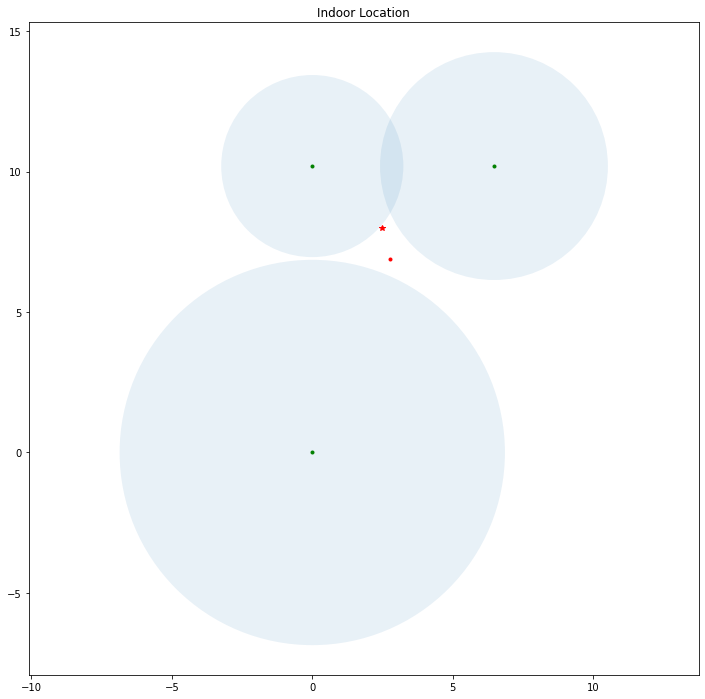

In [10]:
final_position = get_positions(dis,tmp_sensors,true_position,way,average_in_position)
print("final position")
print(final_position)